# **Fashion MNIST Classification**
A FCNN (Fully Connected Neural Network) and CNN (Convolutional Nerual Network) have been modeled

## Import required packages

In [1]:
import torch 
from torchvision import transforms,datasets
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler
import matplotlib.pyplot as plt 
import numpy as np 


## Defining our Transforms

In [2]:
transform=transforms.Compose([transforms.ToTensor()])
# To get the Normalization values do the follwing after downloading train data
# print(train_data.data.float().mean()/255)
# print(train_data.data.float().std()/255)

## Gathering the train and test data

In [3]:
train_data=datasets.FashionMNIST('data',train=True,download=True,transform=transform)
test_data=datasets.FashionMNIST('data',train=False,download=True,transform=transform)

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Defining our Train, Valid and Test Dataloaders

In [4]:
valid_size=0.2
train_length=len(train_data)

indices=[i for i in range(train_length)]
np.random.shuffle(indices)

split=int(np.floor(valid_size*train_length))
train_idx=indices[split:]
valid_idx=indices[:split]


train_sampler=SubsetRandomSampler(train_idx)
valid_sampler=SubsetRandomSampler(valid_idx)

num_workers=0
batch_size=20
train_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=train_sampler,num_workers=num_workers)
valid_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=train_sampler,num_workers=num_workers)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=batch_size,num_workers=num_workers)

# This is for debugging
print(f"Training data size : {train_idx.__len__()}, Validation data size : {valid_idx.__len__()}, Test data size : {test_loader.dataset.__len__()}")

Training data size : 48000, Validation data size : 12000, Test data size : 10000


In [5]:
# checking our data
dataiter=iter(train_loader)
images,labels=dataiter.next()
print(images, images.shape, len(images), images[0].shape)
print()
print(labels,labels.shape,len(labels))

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.4157, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.8863, 0.1137, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.8784, 0.0353, 0.0000],
          ...,
          [0.0000, 0.0000, 0.3137,  ..., 0.7529, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.2902,  ..., 0.7451, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1961, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..

## Visualizing a Training batch

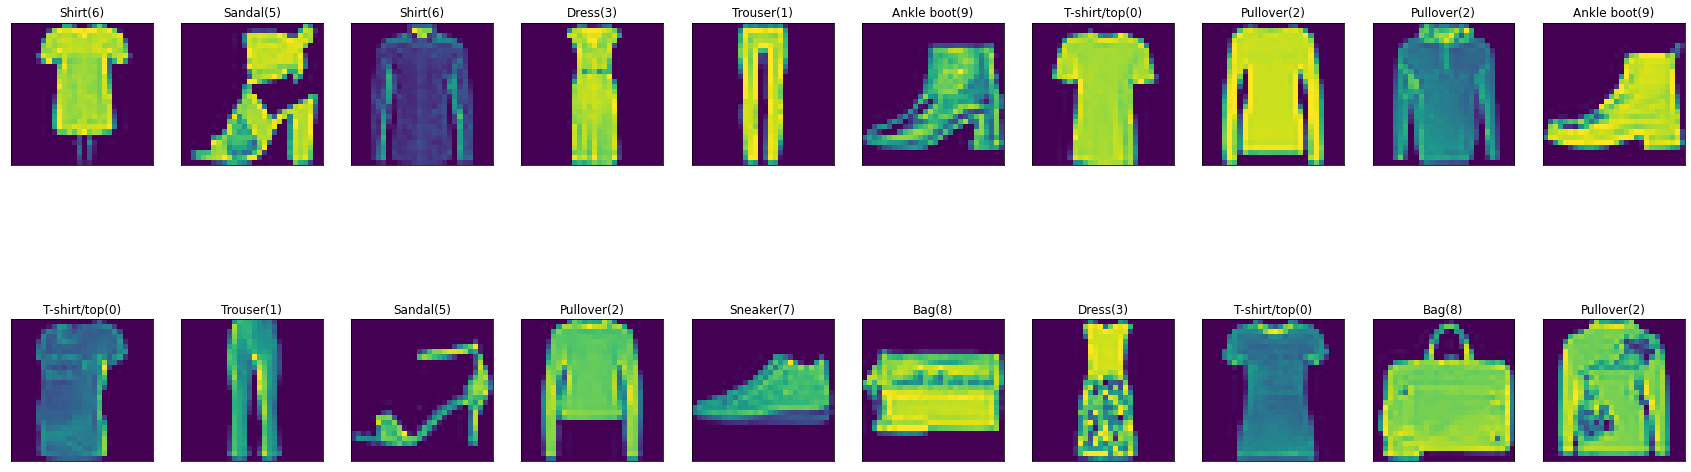

In [6]:
fashion_class={
    0:"T-shirt/top",
    1:"Trouser",
    2:"Pullover",
    3:"Dress",
    4:"Coat",
    5:"Sandal",
    6:"Shirt",
    7:"Sneaker",
    8:"Bag",
    9:"Ankle boot"
}

fig=plt.figure(figsize=(30,10))
for i in range(len(labels)):
    ax=fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    plt.imshow(np.squeeze(images[i]))
    ax.set_title(f"{fashion_class[labels[i].item()]}({labels[i].item()})")
    

## Defining our Neural Net Architecture

In [7]:

# Model 1 : This model has dropout set to a certain value
# NOTE : When we want to use dropout we ensure we run train() method on our model --- during training , if not required we should use eval() method --- validation and testing
class FNet(nn.Module):
    def __init__(self):
        super(FNet,self).__init__()
        self.fc1=nn.Linear(784,512)
        self.fc2=nn.Linear(512,256)
        self.out=nn.Linear(256,10)
        
        # Dropout probability - set for avoiding overfitting
        self.dropout=nn.Dropout(0.2)

    def forward(self,x):
        x = x.view(-1, 28 * 28)        
        x=self.dropout(torch.sigmoid(self.fc1(x)))
        x=self.dropout(torch.sigmoid(self.fc2(x)))
        x=self.out(x)
        return x

class convNet(nn.Module):
  def __init__(self):
    super(convNet,self).__init__()
    self.conv1=nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,padding=1,stride=1)
    self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1,stride=1)
    self.pool=nn.MaxPool2d(kernel_size=2,stride=2)


    self.fc1=nn.Linear(7*7*32,512)
    self.fc2=nn.Linear(512,256)
    self.out=nn.Linear(256,10)
    self.dropout=nn.Dropout(0.2)

  def forward(self,x):
    x=self.pool(F.relu(self.conv1(x)))
    x=self.pool(F.relu(self.conv2(x)))
    x=x.view(-1,7*7*32)
    x=self.dropout(F.relu(self.fc1(x)))
    x=self.dropout(F.relu(self.fc2(x)))
    x=self.out(x)
    return x
    

In [8]:
model_1=FNet()
model_2=convNet()

use_cuda=True
if use_cuda and torch.cuda.is_available():
  model_1.cuda()
  model_2.cuda()


print(model_1,'\n\n\n\n',model_2,'\n\n\n\n','On GPU : ',torch.cuda.is_available())

FNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 



 convNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 



 On GPU :  True


## Defining our Loss Function

In [9]:
# Loss Function
# If we did not compute softmax at output use nn.CrossentropyLoss() else use nn.NLLLoss()
criterion=nn.CrossEntropyLoss()


## Training and Validation Phase

In [10]:
def trainNet(model,lr):
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)


    # Number of epochs to train for
    loss_keeper={'train':[],'valid':[]}
    epochs=50

    # minimum validation loss ----- set initial minimum to infinity
    valid_loss_min = np.Inf 

    for epoch in range(epochs):
        train_loss=0.0
        valid_loss=0.0

        """
        TRAINING PHASE
        """
        model.train() # TURN ON DROPOUT for training
        for images,labels in train_loader:
            if use_cuda and torch.cuda.is_available():
                images,labels=images.cuda(),labels.cuda()
            optimizer.zero_grad()
            output=model(images)
            loss=criterion(output,labels)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()

        """
        VALIDATION PHASE
        """
        model.eval() # TURN OFF DROPOUT for validation
        for images,labels in valid_loader:
            if use_cuda and torch.cuda.is_available():
                images,labels=images.cuda(),labels.cuda()
            output=model(images)
            loss=criterion(output,labels)
            valid_loss+=loss.item()

        # Calculating loss over entire batch size for every epoch
        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(valid_loader)


        # saving loss values
        loss_keeper['train'].append(train_loss)
        loss_keeper['valid'].append(valid_loss)

        print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}\tValidation Loss : {valid_loss}")
        if valid_loss<=valid_loss_min:
            print(f"Validation loss decreased from : {valid_loss_min} ----> {valid_loss} ----> Saving Model.......")
        z=type(model).__name__
        torch.save(model.state_dict(), z+'_model.pth')
        valid_loss_min=valid_loss
    return(loss_keeper)

In [11]:
m1_loss=trainNet(model_1,0.001)


Epoch : 1	Training Loss : 0.5713734511472285	Validation Loss : 0.39836739369047186
Validation loss decreased from : inf ----> 0.39836739369047186 ----> Saving Model.......

Epoch : 2	Training Loss : 0.40332381018437446	Validation Loss : 0.36330949280255787
Validation loss decreased from : 0.39836739369047186 ----> 0.36330949280255787 ----> Saving Model.......

Epoch : 3	Training Loss : 0.36436437474718936	Validation Loss : 0.31846869574704517
Validation loss decreased from : 0.36330949280255787 ----> 0.31846869574704517 ----> Saving Model.......

Epoch : 4	Training Loss : 0.33832650106865914	Validation Loss : 0.29416712121494737
Validation loss decreased from : 0.31846869574704517 ----> 0.29416712121494737 ----> Saving Model.......

Epoch : 5	Training Loss : 0.3200391346759473	Validation Loss : 0.27673846632940696
Validation loss decreased from : 0.29416712121494737 ----> 0.27673846632940696 ----> Saving Model.......

Epoch : 6	Training Loss : 0.3041076678254952	Validation Loss : 0.26

In [12]:
m1_loss

{'train': [0.5713734511472285,
  0.40332381018437446,
  0.36436437474718936,
  0.33832650106865914,
  0.3200391346759473,
  0.3041076678254952,
  0.28935977881075814,
  0.2808982925551633,
  0.26913573533218976,
  0.262641812460109,
  0.25483825714773656,
  0.24808745863013124,
  0.23923072837331952,
  0.2332842793428184,
  0.22504698292856726,
  0.22124746695083256,
  0.21666762757173275,
  0.21231934085391307,
  0.20392125022558805,
  0.20072027030784131,
  0.19978502060015066,
  0.19451070937066106,
  0.19119697297923266,
  0.18671282243497747,
  0.17983954221965784,
  0.178856961511774,
  0.17540550472893907,
  0.17031180475091484,
  0.16688226470053147,
  0.16426355763731407,
  0.16064261163963237,
  0.15444671609994354,
  0.15458961716382572,
  0.14932586322237815,
  0.14700197621064337,
  0.14696771162663935,
  0.14292669832080718,
  0.14000946560307057,
  0.14056989452206228,
  0.13726345007683752,
  0.13359667852322066,
  0.13221521712196893,
  0.13029662246853452,
  0.1275520

In [13]:
m2_loss=trainNet(model_2,0.001)


Epoch : 1	Training Loss : 0.4822358698444441	Validation Loss : 0.3270762578072026
Validation loss decreased from : inf ----> 0.3270762578072026 ----> Saving Model.......

Epoch : 2	Training Loss : 0.30753009125978376	Validation Loss : 0.2518682210989452
Validation loss decreased from : 0.3270762578072026 ----> 0.2518682210989452 ----> Saving Model.......

Epoch : 3	Training Loss : 0.2582530663709622	Validation Loss : 0.19726231790652188
Validation loss decreased from : 0.2518682210989452 ----> 0.19726231790652188 ----> Saving Model.......

Epoch : 4	Training Loss : 0.2261096736782929	Validation Loss : 0.18398194442202415
Validation loss decreased from : 0.19726231790652188 ----> 0.18398194442202415 ----> Saving Model.......

Epoch : 5	Training Loss : 0.20094888373219874	Validation Loss : 0.15688568457146176
Validation loss decreased from : 0.18398194442202415 ----> 0.15688568457146176 ----> Saving Model.......

Epoch : 6	Training Loss : 0.17755166650895263	Validation Loss : 0.14422466

In [14]:
m2_loss

{'train': [0.4822358698444441,
  0.30753009125978376,
  0.2582530663709622,
  0.2261096736782929,
  0.20094888373219874,
  0.17755166650895263,
  0.15982473263992383,
  0.14243702443178335,
  0.12960414957999697,
  0.11665990345152749,
  0.10507309147713689,
  0.09553140321563963,
  0.08683765788042062,
  0.08136152901184611,
  0.07834818864479909,
  0.07152384685146633,
  0.06471348146829556,
  0.06542937912698023,
  0.06145707659231023,
  0.05575448910903271,
  0.056222481315686516,
  0.05383445834673773,
  0.05186387716626994,
  0.04926332099418631,
  0.04553326579273581,
  0.04585066168188271,
  0.04483601416520772,
  0.0439874375356926,
  0.045594473197064764,
  0.04155908477852807,
  0.04055393329235523,
  0.044780770514636865,
  0.039897666677460364,
  0.037659841149678026,
  0.03932909614436749,
  0.038883515141486524,
  0.03662514198554903,
  0.03744928579454214,
  0.03384367349277302,
  0.03750126943412374,
  0.038058091639074386,
  0.03475050823807461,
  0.035863529303146895

## Loading model from Lowest Validation Loss

In [15]:
# Loading the model from the lowest validation loss 
model_1.load_state_dict(torch.load('FNet_model.pth'))
model_2.load_state_dict(torch.load('convNet_model.pth'))


<All keys matched successfully>

In [16]:
print(model_1.state_dict,'\n\n\n\n',model_2.state_dict)

<bound method Module.state_dict of FNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)> 



 <bound method Module.state_dict of convNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)>


## Plotting Training and Validation Losses

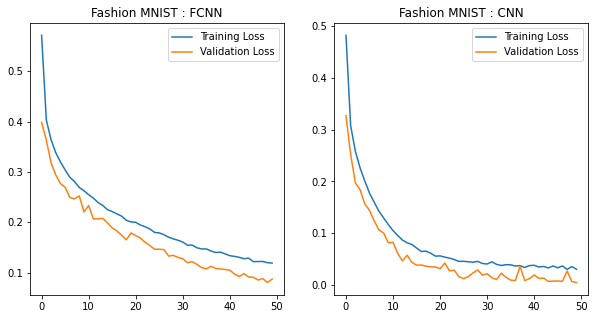

In [17]:
title=['FCNN','CNN']
model_losses=[m1_loss,m2_loss]
fig=plt.figure(1,figsize=(10,5))
idx=1
for i in model_losses:
  ax=fig.add_subplot(1,2,idx)
  ax.plot(i['train'],label="Training Loss")
  ax.plot(i['valid'],label="Validation Loss")
  ax.set_title('Fashion MNIST : '+title[idx-1])
  idx+=1
  plt.legend();

## Testing Phase

In [18]:
def test(model):
    correct=0
    test_loss=0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval() # test the model with dropout layers off
    for images,labels in test_loader:
        if use_cuda and torch.cuda.is_available():
            images,labels=images.cuda(),labels.cuda()
        output=model(images)
        loss=criterion(output,labels)
        test_loss+=loss.item()
        _,pred=torch.max(output,1)
        correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

        for i in range(batch_size):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1


    test_loss=test_loss/len(train_loader)
    print(f'For {type(model).__name__} :')
    print(f"Test Loss: {test_loss}")
    print(f"Correctly predicted per class : {class_correct}, Total correctly perdicted : {sum(class_correct)}")
    print(f"Total Predictions per class : {class_total}, Total predictions to be made : {sum(class_total)}\n")
    for i in range(10):
      if class_total[i] > 0:
          print(f"Test Accuracy of class {i} : {float(100 * class_correct[i] / class_total[i])}% where {int(np.sum(class_correct[i]))} of {int(np.sum(class_total[i]))} were predicted correctly")
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print(f"\nOverall Test Accuracy : {float(100. * np.sum(class_correct) / np.sum(class_total))}% where {int(np.sum(class_correct))} of {int(np.sum(class_total))} were predicted correctly")
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, labels = dataiter.next()

    # get sample outputs
    if use_cuda and torch.cuda.is_available():
      images,labels=images.cuda(),labels.cuda()
    output = model(images)
    
    # convert output probabilities to predicted class
    _, preds = torch.max(output, 1)
    # prep images for display
    images = images.cpu().numpy()

    fig = plt.figure(figsize=(15, 20))
    for idx in np.arange(batch_size):
        ax = fig.add_subplot(5, batch_size/5, idx+1, xticks=[], yticks=[])
        plt.imshow(np.squeeze(images[idx]))
        ax.set_title("{}-{} for ({}-{})".format(str(preds[idx].item()), fashion_class[preds[idx].item()],str(labels[idx].item()),fashion_class[labels[idx].item()]),
                    color=("blue" if preds[idx]==labels[idx] else "red"))

## Visualizing a Test batch with results

### FCNN

For FNet :
Test Loss: 0.08526107708061015
Correctly predicted per class : [872.0, 980.0, 834.0, 884.0, 871.0, 962.0, 661.0, 982.0, 981.0, 929.0], Total correctly perdicted : 8956.0
Total Predictions per class : [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0], Total predictions to be made : 10000.0

Test Accuracy of class 0 : 87.2% where 872 of 1000 were predicted correctly
Test Accuracy of class 1 : 98.0% where 980 of 1000 were predicted correctly
Test Accuracy of class 2 : 83.4% where 834 of 1000 were predicted correctly
Test Accuracy of class 3 : 88.4% where 884 of 1000 were predicted correctly
Test Accuracy of class 4 : 87.1% where 871 of 1000 were predicted correctly
Test Accuracy of class 5 : 96.2% where 962 of 1000 were predicted correctly
Test Accuracy of class 6 : 66.1% where 661 of 1000 were predicted correctly
Test Accuracy of class 7 : 98.2% where 982 of 1000 were predicted correctly
Test Accuracy of class 8 : 98.1% where 981 of 1000 were pre

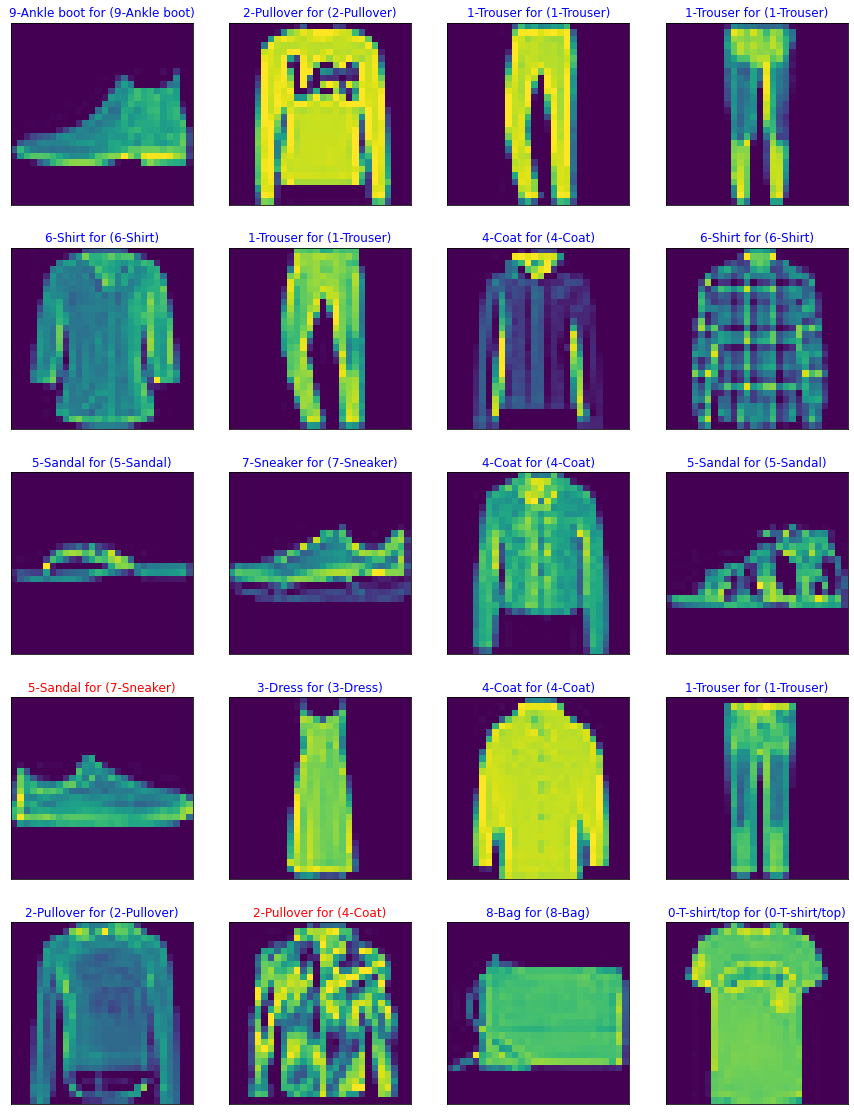

In [19]:
test(model_1)

### CNN

For convNet :
Test Loss: 0.16279748079078876
Correctly predicted per class : [850.0, 986.0, 867.0, 921.0, 865.0, 985.0, 777.0, 975.0, 976.0, 964.0], Total correctly perdicted : 9166.0
Total Predictions per class : [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0], Total predictions to be made : 10000.0

Test Accuracy of class 0 : 85.0% where 850 of 1000 were predicted correctly
Test Accuracy of class 1 : 98.6% where 986 of 1000 were predicted correctly
Test Accuracy of class 2 : 86.7% where 867 of 1000 were predicted correctly
Test Accuracy of class 3 : 92.1% where 921 of 1000 were predicted correctly
Test Accuracy of class 4 : 86.5% where 865 of 1000 were predicted correctly
Test Accuracy of class 5 : 98.5% where 985 of 1000 were predicted correctly
Test Accuracy of class 6 : 77.7% where 777 of 1000 were predicted correctly
Test Accuracy of class 7 : 97.5% where 975 of 1000 were predicted correctly
Test Accuracy of class 8 : 97.6% where 976 of 1000 were 

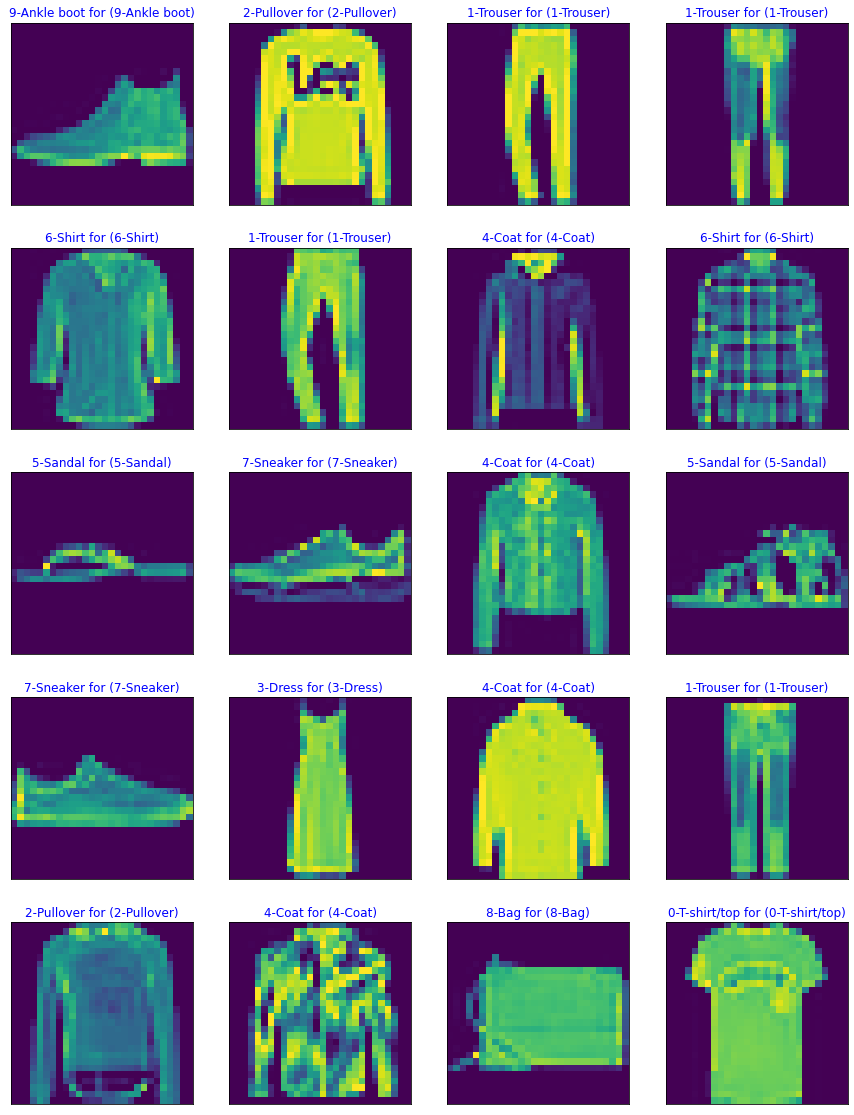

In [20]:
test(model_2)